# Test

In [12]:
# import packages needed 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import perf_data

# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')



import pandas as pd
import os, json, sys, glob, pickle
import requests


from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp
import atomsci.ddm.pipeline.diversity_plots as dp

In [3]:
response_col = "class"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"
split_uuid = "5f834022-46ac-4c7b-bca1-9573f6eb940f" # scaffold
# Set up file locations 
dataset_file = '/home/jupyter/hERG_Analysis/herg_chembl_curated.csv' 
odir = '/home/jupyter/hERG_Analysis/Models'

params = {
        "verbose": "True",
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "classification",
        "dataset_key": dataset_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        # using previously split data
        "previously_split": "True",
        "split_uuid" : split_uuid,
        "split_only": "False",
        # not needed becuase already using splits established previously
        # "split_strategy": "train_valid_test",
        "splitter": "scaffold",
        # "split_valid_frac": "0.10",
        # "split_test_frac": "0.10",
        "featurizer": "ecfp",
        "model_type": "xgboost",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": odir,
    #    "rf_estimators": 64,
     #   "rf_max_depth": 24,
      #  "rf_max_features": 16,
       # "model_choice_score_type": "recall"
        # "ampl_version": " "
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2024-05-03 16:40:37,356 Previous dataset split restored


In [4]:
pred_data_test = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results_test = pred_data_test.get_prediction_results()
pred_results_test

{'roc_auc_score': 0.7525319586555234,
 'prc_auc_score': 0.7045571867652014,
 'cross_entropy': 0.5865911441214937,
 'precision': 0.6686746987951807,
 'recall_score': 0.6271186440677966,
 'npv': 0.7105263157894737,
 'accuracy_score': 0.6928934010152284,
 'bal_accuracy': 0.68683121143482,
 'kappa': 0.3758150252690565,
 'matthews_cc': 0.37642153214757473,
 'confusion_matrix': [[[486, 165], [198, 333]]],
 'num_compounds': 1182}

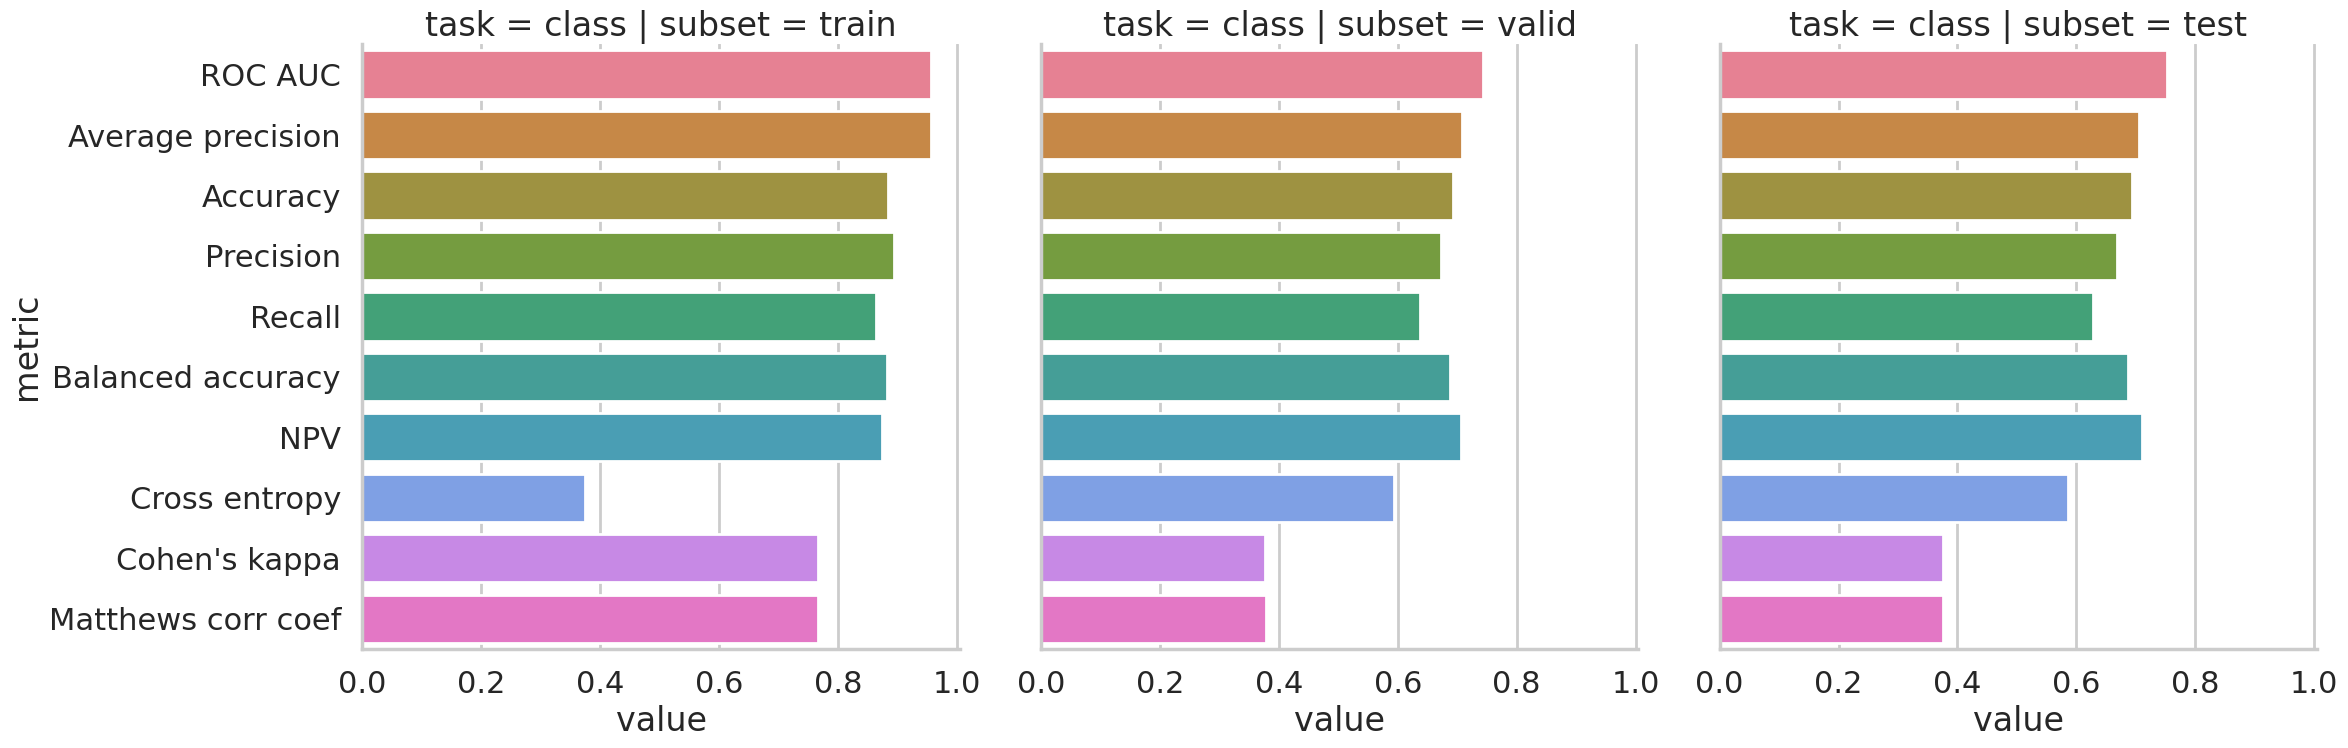

In [5]:
pp.plot_model_metrics(pl, plot_size=8)

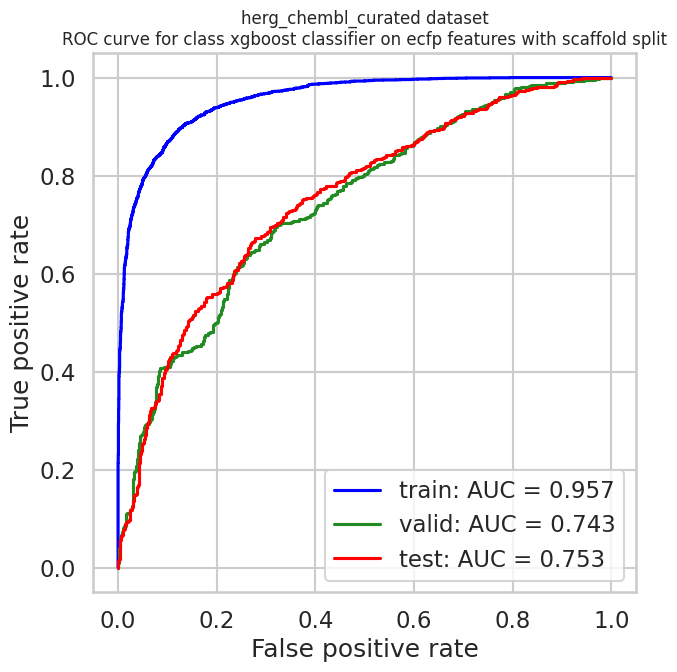

In [6]:
pp.plot_ROC_curve(pl)

In [2]:
path = '/home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_ea540e5c-e587-4fd7-86d5-84b70a9acb7b.tar.gz'

In [3]:
#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=path, model_type='best_model', featurization=None, verbose=False)

2024-05-03 19:52:50,987 /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_ea540e5c-e587-4fd7-86d5-84b70a9acb7b.tar.gz, 1.6.0
2024-05-03 19:52:50,989 Version compatible check: /home/jupyter/hERG_Analysis/Models/herg_chembl_curated_model_ea540e5c-e587-4fd7-86d5-84b70a9acb7b.tar.gz version = "1.6", AMPL version = "1.6"
2024-05-03 19:52:51,037 ['ampl_version', 'time_generated', 'time_built', 'dataset_hash', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


num_model_tasks is deprecated and its value is ignored.


In [9]:
def create_prediction_pipeline_from_file(params, reload_dir, model_path=None, model_type='best_model', featurization=None,
                                         verbose=True):
    import logging
    import tarfile
    import os
    import tempfile
    import json
    import copy
    from atomsci.ddm.utils import file_utils as futils
    from atomsci.ddm.pipeline import model_pipeline as mp
    from atomsci.ddm.pipeline import featurization as feat
    from atomsci.ddm.pipeline import model_wrapper

    log = logging.getLogger('ATOM')

    if model_path is not None:
        if reload_dir is None:
            reload_dir = tempfile.mkdtemp()
        else:
            os.makedirs(reload_dir, exist_ok=True)
        with tarfile.open(model_path, mode='r:gz') as tar:
            futils.safe_extract(tar, path=reload_dir)
    elif reload_dir is None:
        raise ValueError("Either reload_dir or model_path must be specified.")

    config_file_path = os.path.join(reload_dir, 'model_metadata.json')
    with open(config_file_path) as f:
        config = json.loads(f.read())

    if hasattr(params, 'model_metadata'):
        params.model_metadata = model_metadata
    else:
        config = model_metadata 

    model_params = parse.wrapper(model_metadata)
    orig_params = copy.deepcopy(model_params)
    model_params.save_results = False
    model_params.output_dir = reload_dir

    if params is not None:
        model_params.update_from_params(params)  # Hypothetical method to update model parameters

    if featurization is None:
        featurization = feat.create_featurization(model_params)

    log.info("Featurization = %s" % str(featurization))
    pipeline = mp.ModelPipeline(model_params)
    pipeline.orig_params = orig_params
    pipeline.model_metadata = model_metadata  # Set the model_metadata attribute

    pipeline.model_wrapper = model_wrapper.create_model_wrapper(pipeline.params, featurization)
    if verbose:
        pipeline.log.setLevel(logging.DEBUG)
    else:
        pipeline.log.setLevel(logging.CRITICAL)

    model_dir = os.path.join(reload_dir, model_type)
    pipeline.model_wrapper.reload_model(model_dir)

    return pipeline

In [13]:
pp.plot_prec_recall_curve(best_model_pipe)

AttributeError: 'ModelPipeline' object has no attribute 'model_metadata'

In [9]:
best_model_pipe.model_metadata

AttributeError: 'ModelPipeline' object has no attribute 'model_metadata'

In [10]:
best_model_pipe.params

Namespace(bucket='public', dataset_key='/home/jupyter/hERG_Analysis/herg_chembl_curated.csv', dataset_name='herg_chembl_curated', dataset_oid=None, datastore=False, id_col='compound_id', min_compound_number=200, response_cols=['class'], save_results=False, smiles_col='rdkit_smiles', max_dataset_rows=0, autoencoder_bucket=None, autoencoder_key=None, autoencoder_type='molvae', mol_vae_model_file=None, class_number=2, class_name=None, descriptor_bucket='public', descriptor_key=None, descriptor_oid=None, descriptor_spec_bucket='', descriptor_spec_key='/home/jupyter/AMPL/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv', descriptor_type='moe', moe_threads=-1, ecfp_radius=2, ecfp_size=1024, embedding_model_uuid=None, embedding_model_collection=None, embedding_model_path=None, featurizer='ecfp', model_choice_score_type='roc_auc', model_type='xgboost', prediction_type='classification', previously_featurized=True, uncertainty=False, verbose=False, optimizer_type='adam', mordred_cpus=N

In [12]:
response_col = "class"
compound_id = "compound_id"
smiles_col = "rdkit_smiles"
split_uuid = "5f834022-46ac-4c7b-bca1-9573f6eb940f" # scaffold
# Set up file locations 
dataset_file = '/home/jupyter/hERG_Analysis/herg_chembl_curated.csv' 
odir = '/home/jupyter/hERG_Analysis/Models'

params = {
        "verbose": "True",
        "datastore": "False",
        "save_results": "False",
        "prediction_type": "classification",
        "dataset_key": dataset_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        # using previously split data
        "previously_split": "True",
        "split_uuid" : split_uuid,
        "split_only": "False",
        # not needed becuase already using splits established previously
        # "split_strategy": "train_valid_test",
        "splitter": "scaffold",
        # "split_valid_frac": "0.10",
        # "split_test_frac": "0.10",
        "featurizer": "ecfp",
        "model_type": "xgboost",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": odir,
        "xgb_colsample_bytree": 1.0,
        "xgb_gamma": 0.0418279242901785, 
        "xgb_learning_rate": 0.23272554100636283, 
        "xgb_max_depth": 6, 
        "xgb_min_child_weight": 1.0, 
        "xgb_n_estimators": 100, 
        "xgb_subsample": 1.0

    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

In [13]:
pred_data_test = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results_test = pred_data_test.get_prediction_results()
pred_results_test

{'roc_auc_score': 0.7515252501583829,
 'prc_auc_score': 0.7186367700732679,
 'cross_entropy': 0.5965669338716136,
 'precision': 0.6867469879518072,
 'recall_score': 0.6440677966101694,
 'npv': 0.7236842105263158,
 'accuracy_score': 0.7081218274111675,
 'bal_accuracy': 0.7022182301023198,
 'kappa': 0.4067663463300951,
 'matthews_cc': 0.4074228038169193,
 'confusion_matrix': [[[495, 156], [189, 342]]],
 'num_compounds': 1182}

In [ ]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)